<a href="https://colab.research.google.com/github/este7734/Web_scraping_project/blob/master/Die_Zeit_Web_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='yellow'> Die Zeit Web Scraper </font>

---



## Import Dependencies

In [ ]:
# Import libraries for processing web text
from bs4 import BeautifulSoup
import requests

from textblob import TextBlob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lxml import html

# Import these dependencies if using Google Colab 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Define All Functions

In [ ]:
#@title Functions Hidden
# Get content of the webpage in an html string format by passing a url 
def get_html(url):
    page = requests.get(url)
    html_out = html.fromstring(page.content)
    text = page.text
    return html_out, text

# Convert html into soup to enable soup menthods
def get_soup(html_string):
    soup = BeautifulSoup(html_string, 'html.parser')
    return soup

# Extract hyperlinks from soup
def get_soup_links(soup):
    links = []
    for link in soup.find_all('a'):
        out_link = link.get('href')
        links.append(out_link)
    return links

# This function is for use with only the Topic pages on diezeit.com
# Search through ALL links and filter for only those that are for actual articles
# links are formatted differently 
def get_articles_topics(links, old_url_set):
    articles = []
    for link in links:
        try:
            if 'https://www.zeit.de'in link:
              for topic in die_zeit_topics:
                if topic in link:
                  link = link
                  if url_check(old_url_set, link) == False:
                    articles.append(link)
        except:
            continue
    articles = list(set(articles))
    old_url_set = set(articles + list(old_url_set))       
    return articles, old_url_set

# Check if new urls exists in the old_url_set. if yes, return True; if no, return False
# This function is used in the get_articles_topics function
def url_check(old_url_set, url):
    url_set = set([url])
    test_set = old_url_set & url_set
    if len(test_set) == 0:
        check = False
    else:
        check = True
    return check

# Get html strings from list of article weblinks
def get_html(articles):
    soup_list = []
    for article in articles:
        _, text = get_html(article)
        soup = get_soup(text)
        soup_list.append(soup)
    return soup_list

  # Break out article_body, article_headline, and article_date from each article in provided hyperlinks and put into a dictionary called: out_list
def get_elements(soup_list, articles):
    out_list = []
    i = 0
    for article in soup_list:
        link = articles[i] # I don't think this is used at all here, which means there is no reason to require the second argument: articles
        i += 1
        try:
            article_body = article.find_all(body_class, {'class': body_tag})
            article_p = []
            for item in article_body:
                p_list = item.find_all('p')
                for p in p_list:
                    article_p.append(p.text)
            out_text = ' '.join(article_p)
            if out_text == '':
              continue
            if out_text.startswith('Besondere Reportagen'):
              continue
            out_dict = dict([('Text',out_text),('url',link)])
            out_list.append(out_dict)
        except:
            print('Unable to decode...skipping article...')
            continue

    return out_list  

## Define URL Variables and Run Functions

<font color='orange'>Step 1.</font> Instantiate `tags and values`. Then instntiate `old_url_set` to be used in the `get_articles_topics` function. This is a running log of article links that will be compiled by iterating from steps 2 - 3.

In [ ]:
# Die Zeit classes and tags
body_class = 'div'
headline_class = 'h1'
date_class = 'div'

body_tag = 'article-body article-body--article'
headline_tag = 'headline article__item'
date_tag = 'metadata'

# Instantiate empty set to use a running list of hyperlinks while 
# running the scrape iterations
old_url_set = set([])

## Scrape Die Zeit Topics pages for all the most recent news articles. <font color='orange'>*Run Steps 2 - 3 for each instance of `url` variable, before moving on to the next steps*</font>

<font color='orange'>Step 2.</font> Define variables for each of Die Zeit main topics pages. Run this cell for each iteration by uncommenting a different url each time.

In [ ]:
# Define url variables
# NOTE: You must run these individually through the end of this section
# I didn't have time to figure out how to loop through all of them properly
# There is a section at the very bottom where you can see that I attempted but ran
# into a problem on one of the last functions. 

# Die Zeit Links
#url = r'https://www.zeit.de/index'
#url = r'https://www.zeit.de/politik/index'
#url = r'https://www.zeit.de/gesellschaft/index'
#url = r'https://www.zeit.de/wirtschaft/index'
#url = r'https://www.zeit.de/wissen/index'
#url = r'https://www.zeit.de/digital/index'
#url = r'https://www.zeit.de/entdecken/index'
url = r'https://www.zeit.de/zeit-magazin/index'

die_zeit_topics = ['politik/index', 'gesellschaft', 'wirtschaft', 'wissen',
                   'digital', 'entdecken']

## Scraper

<font color='orange'>Step 3.</font> Get HTML srting from web `url`

In [ ]:
# Pass the each instance of `url` variable to return the web page in HTML format and convert it to a string
html_string = str(get_html(url))
# Pass the HTML string (of the web page) to get its soup
soup = get_soup(html_string)
# Find ALL links on within the soup
links = get_soup_links(soup)
# Use this for Topics Pages only
# Filter out only those links that are for actual articles. We only want the "good" links
# This filters out things like links to images and advertisements or non-news worthy pages
articles, old_url_set = get_articles_topics(links, old_url_set)
print(len(articles))
# Print out the running list of hyperlinks to see how many you have
print(len(old_url_set))

3
161


## Pre-Run List of URLs

In [ ]:
#@title Double-click for entire old_url_set
old_url_set = {'https://www.zeit.de/2020/27/klimaforschung-ideologie-thea-dorn-wissenschaft-warnung',
 'https://www.zeit.de/2020/27/unternehmen-wirtschaft-staat-wirecard-toennies-lufthansa-cure-vac',
 'https://www.zeit.de/2020/27/wirecard-bilanzskandal-betrug-finanzaufsichtsbehoerde-bafin-digitaler-zahlungsdienst',
 'https://www.zeit.de/angebote/bp-wissenspodcast/index',
 'https://www.zeit.de/digital/2020-06/corona-warn-app-bugs-hinweise',
 'https://www.zeit.de/digital/2020-06/covid-19-corona-warn-app-infizierte-warnung',
 'https://www.zeit.de/digital/2020-06/eu-kommission-bericht-dsgvo-datenschutz',
 'https://www.zeit.de/digital/2020-06/margrethe-vestager-tech-konzerne-usa-silicon-valley',
 'https://www.zeit.de/digital/2020-06/medienpreis-grimme-podcast-christian-drosten',
 'https://www.zeit.de/digital/2020-06/polizeigewalt-usa-proteste-digitale-ueberwachung-buergerrechtler-faq',
 'https://www.zeit.de/digital/2020-06/twitter-donald-trump-us-praesident-warnhinweis',
 'https://www.zeit.de/digital/datenschutz/2020-06/datenschutz-facebook-bundesgerichtshof-stoppung-sammlung-nutzerdaten-kartellamt',
 'https://www.zeit.de/digital/datenschutz/2020-06/hass-im-internet-gesetz-bundestag-hasskommentare-datenschutz',
 'https://www.zeit.de/digital/datenschutz/2020-06/kindesmissbrauch-vorratsdatenspeicherung-kinderpornografie-innenministerkonferenz-franziska-giffey-bekaempfung',
 'https://www.zeit.de/digital/datenschutz/2020-06/spionage-ueberwachung-nso-marokko-journalist-pegasus',
 'https://www.zeit.de/digital/datenschutz/index',
 'https://www.zeit.de/digital/games/2020-05/spielekonsole-sport-playstation-xbox-nintendo-wii',
 'https://www.zeit.de/digital/games/2020-05/spielekonsolen-videospiele-gaming-konsolenkauf-spiele-einsteiger-tipps',
 'https://www.zeit.de/digital/games/2020-06/gaming-szene-sexuelle-belaestigung-frauen-metoo',
 'https://www.zeit.de/digital/games/2020-06/spielekonsole-sony-playstation-digital-edition-laufwerk',
 'https://www.zeit.de/digital/games/2020-06/the-last-of-us-part-2-computerspiel-storytelling-gaming',
 'https://www.zeit.de/digital/games/index',
 'https://www.zeit.de/digital/index',
 'https://www.zeit.de/digital/internet/2020-03/it-sicherheit-datenschutz-digitalisierung-internet-digitalpodcast',
 'https://www.zeit.de/digital/internet/2020-06/3-d-druck-technologie-prothesen-gesundheit-waffen-umwelt',
 'https://www.zeit.de/digital/internet/2020-06/google-news-lizenzvertraege-online-journalismus-inhalte',
 'https://www.zeit.de/digital/internet/2020-06/hassrede-facebook-werbung-boykott-unternehmen-usa-soziale-medien',
 'https://www.zeit.de/digital/internet/2020-06/olg-dresden-ein-prozent-hassorganisation-sperre-facebook',
 'https://www.zeit.de/digital/internet/2020-06/pornografie-minderjaehrige-medienschutz-pornoplattform-sperre',
 'https://www.zeit.de/digital/internet/2020-06/strafverfolgung-netz-bundestag-hass-hetze-drohungen-haertere-strafen-gesetz',
 'https://www.zeit.de/digital/internet/2020-06/twitter-sprachnachrichten-social-media-audio-aufnahme',
 'https://www.zeit.de/digital/internet/index',
 'https://www.zeit.de/digital/mobil/2020-05/samsung-galaxy-z-flip-klapp-handy',
 'https://www.zeit.de/digital/mobil/2020-06/apple-pay-app-store-eu-kommission-wettbewerbsverfahren-kartell',
 'https://www.zeit.de/digital/mobil/2020-06/corona-app-tracing-datenschutz-faq',
 'https://www.zeit.de/digital/mobil/2020-06/corona-warn-app-gesundheitsaemter-anfragen-hotline-nutzer-downloads',
 'https://www.zeit.de/digital/mobil/2020-06/robert-habeck-gruene-corona-warn-app-aeltere-smartphones-menschen-kritik',
 'https://www.zeit.de/digital/mobil/2020-06/tracing-app-corona-datenschutz-standortdaten-bluetooth-virus-bekaempfung',
 'https://www.zeit.de/digital/mobil/2020-06/wwdc-2020-apple-worldwide-developers-conference-entwickler-konferenz-ios-mac',
 'https://www.zeit.de/digital/mobil/index',
 'https://www.zeit.de/entdecken/2020-06/giessen-hessen-giesskannenmuseum-elefantenklo-stadttheater',
 'https://www.zeit.de/entdecken/index',
 'https://www.zeit.de/entdecken/reisen/2020-06/europareise-reisewarnung-aufgehoben-eu-sommer-ferien-auswaertiges-amt-faq',
 'https://www.zeit.de/entdecken/reisen/2020-06/flugreisen-airlines-kurzurlaub-luftfahrtbranche-coronavirus',
 'https://www.zeit.de/entdecken/reisen/2020-06/gesundheitsminister-jens-spahn-warnung-reisen-corona-ischgl-ballermann',
 'https://www.zeit.de/entdecken/reisen/2020-06/mallorca-tourismus-medien-ballermann-corona-krise',
 'https://www.zeit.de/entdecken/reisen/2020-06/sommerferien-urlaub-deutschland-tourismus-nordsee-ostsee-straende',
 'https://www.zeit.de/entdecken/reisen/2020-06/veneding-coronavirus-tourismus-entspannung-oekosystem',
 'https://www.zeit.de/gesellschaft/2020-06/corona-pandemie-sterbefaelle-mai-vergleich-vorjahre',
 'https://www.zeit.de/gesellschaft/2020-06/corona-reisebeschraenkungen-warendorf-guetersloh-niedersachsen',
 'https://www.zeit.de/gesellschaft/2020-06/goettingen-hochhauskomplex-quarantaene-bewohner-angriff-polizei',
 'https://www.zeit.de/gesellschaft/2020-06/grossbritannien-straende-menschen-kontaktbeschraenkungen-coronavirus',
 'https://www.zeit.de/gesellschaft/2020-06/mord-mutter-toechter-ermittlungen-kriminalpodcast',
 'https://www.zeit.de/gesellschaft/familie/2020-06/bertelsmann-studie-frauen-gehalt-muetter-lebenserwerbseinkommen-karriere',
 'https://www.zeit.de/gesellschaft/familie/2020-06/bundesregierung-zugang-familienleistungen-geburtsurkunde-elterngeld-kindergeld',
 'https://www.zeit.de/gesellschaft/familie/2020-06/ehe-fuer-alle-schweiz-beschluss-homosexualitaet-samenspende-svp',
 'https://www.zeit.de/gesellschaft/familie/index',
 'https://www.zeit.de/gesellschaft/index',
 'https://www.zeit.de/gesellschaft/schule/2020-06/anja-karliczek-schulbetrieb-coronavirus-infektionen-bildungsministerin',
 'https://www.zeit.de/gesellschaft/schule/2020-06/inklusion-schule-foerderung-kinder-bertelsmann-studie',
 'https://www.zeit.de/gesellschaft/schule/2020-06/nationaler-bildungsbericht-deutschland-bildung-digitalisierung-schule-ausbildung',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2018-06/racial-profiling-club-rassismus-deutschland',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2018-06/rassismus-ideologie-nationalsozialismus-rassentheorie-antike-mittelalter-genetik',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-05/corona-schutzmassnahmen-lockdown-lockerungen-bundeslaender',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/bundesegierung-touristen-rueckholaktion-kosten-coronavirus',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/corona-ausbruch-goettingen-quarantaene-aufgehoben-wohnkomplex-hochhaus',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/corona-nothilfe-studenten-bundesregierung-ueberbrueckungshilfe',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/coronakrise-peking-china-ausbruch-grossmarkt-massnahmen',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/coronavirus-armin-laschet-kuendigt-lockdown-fuer-kreis-guetersloh-an',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/coronavirus-toennies-schulen-schliessung-yvonne-gebauer',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/ethikrat-stellungnahme-tierschutz-schlachtbetriebe-fleischpreis-tierwohl',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/frankreich-extinction-rebellion-wiedereroeffnung-flughafen-paris',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/genitalverstuemmelung-frauen-maedchen-deutschland-franzsika-giffey',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/grossbritannien-glasgow-messerattacke-verletzte',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/grossbritannien-london-gericht-verurteilung-anschlagsplaene-deutschland',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/kirchenaustritte-deutschland-dbk-ekd-hoechstwert',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/krawalle-stuttgart-ausschreitungen-pluenderungen-polizei-randale-innenstadt',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/migration-griechenland-fluechtlingslager-inseln-moria-lesbos-migrationsministerium',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/reisen-coronavirus-einschraenkungen-sommerurlaub-infektionsschutz-erwartungen-yougov',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/sizilien-sea-watch-3-migranten-mittelmeer-libyen-seenotrettung',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/stuttgart-ausschreitungen-wutbuerger-party-gewalt-polizei-elend',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/stuttgart-innenstadt-pluenderungen-zerstoerung-polizei',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/stuttgart-innenstadt-randale-pluenderungen-festnahmen',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/who-ebola-pandemie-kongo-afrika-ausbruch-eindaemmung',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/2020-06/wildeshausen-schlachthof-coronavirus-quarantaene-landkreis-oldenburg',
 'https://www.zeit.de/gesellschaft/zeitgeschehen/index',
 'https://www.zeit.de/kultur/2020-06/biografie-autor-herkunft-gesellschaft-ansehen-schreiben-autobiografie',
 'https://www.zeit.de/mobilitaet/2020-06/fluggesellschaften-klimaschutz-corona-krise-politische-vorgaben-kurzstreckenfluege-ideen',
 'https://www.zeit.de/politik/ausland/2020-06/covid-19-pandemie-wirtschaftskrise-armut-soforthilfe',
 'https://www.zeit.de/politik/ausland/2020-06/euopaeische-union-china-usa-russland-macht-wirtschaft',
 'https://www.zeit.de/politik/index',
 'https://www.zeit.de/serie/digitale-aengste',
 'https://www.zeit.de/serie/gesellschaftskritik',
 'https://www.zeit.de/wirtschaft/2020-05/anlagetipps-nouriel-roubini-corona-krise-boerse-gold-anleihen',
 'https://www.zeit.de/wirtschaft/2020-06/aktionaere-stimmen-staatseinstieg-bei-lufthansa-zu',
 'https://www.zeit.de/wirtschaft/2020-06/bedingungen-gastarbeit-toennis-szabolcs-sepsi-rumaenisch-ausbeutung-fleischindustrie',
 'https://www.zeit.de/wirtschaft/2020-06/braunkohle-tagebau-garzweiler-besetzt-aktivisten-kohleausstieg',
 'https://www.zeit.de/wirtschaft/2020-06/ferienimmobilien-mallorca-tourismus',
 'https://www.zeit.de/wirtschaft/2020-06/fleischindustrie-schlachtbetriebe-kontrollen-arbeitsbedingungen-arbeitsrecht-verstoesse-deutschland-schlachthoefe',
 'https://www.zeit.de/wirtschaft/2020-06/fleischindustrie-treffen-julia-kloeckner-kritik-gruene-dgb',
 'https://www.zeit.de/wirtschaft/2020-06/fleischproduktion-julia-kloeckner-spitzentreffen-fleischbranche',
 'https://www.zeit.de/wirtschaft/2020-06/guetersloh-toennies-coronavirus-ausbruch-rheda-wiedenbrueck-bundeswehr-lockdown',
 'https://www.zeit.de/wirtschaft/2020-06/usa-soforthilfe-milliarden-dollar-verstorbene',
 'https://www.zeit.de/wirtschaft/2020-06/wirecard-insolvenz-bilanzskandal',
 'https://www.zeit.de/wirtschaft/geldanlage/2020-05/aktienmarkt-deutschland-staatsanleihen-ezb-dax-corona-krise-wirtschaft',
 'https://www.zeit.de/wirtschaft/geldanlage/2020-05/geldanlage-christine-lagarde-ezb-direktoren-notenbankchefs-depots',
 'https://www.zeit.de/wirtschaft/index',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/corona-infektionen-wiesenhof-schlachterei-tests-oldenburg',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/covid-19-toennies-mitarbeiter-bulgare-coronavirus',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/fleischpreise-landwirtschaft-tierwohl-fleischkonsum-deutschland-julia-kloeckner',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/lufthansa-flugausfaelle-erstattung-corona-krise-michael-niggemann',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/toennies-corona-ausbruch-guetersloh-lockdown-armin-laschet',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/toennies-coronavirus-infizierte-qurantaene-guetersloh-lockdown',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/toennies-coronavirus-rheda-wiedenbrueck-alexander-lang',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/wirecard-bafin-finanzaufsicht-eu-kommission-bilanzskandal',
 'https://www.zeit.de/wirtschaft/unternehmen/2020-06/wirecard-finanzmarkt-bilanzskandal-insolvenz-aktienmarkt-dax',
 'https://www.zeit.de/wirtschaft/unternehmen/index',
 'https://www.zeit.de/wirtschaft/zeit-wirtschaftsrat',
 'https://www.zeit.de/wissen/2020-06/corona-ausbreitung-usa-rekordwert-donald-trump',
 'https://www.zeit.de/wissen/2020-06/coronavirus-drogenszene-sucht-abhaengigkeit-polizei-hannover',
 'https://www.zeit.de/wissen/geschichte/index',
 'https://www.zeit.de/wissen/gesundheit/2019-11/masern-impfpflicht-deutschland-gesundheit-bundestag',
 'https://www.zeit.de/wissen/gesundheit/2019-12/schlafstoerung-muedigkeit-erschoepfung-erkrankung-symptom-psychologie',
 'https://www.zeit.de/wissen/gesundheit/2020-05/christian-drosten-corona-virus-streit-medien-virolgie-kritik',
 'https://www.zeit.de/wissen/gesundheit/2020-05/global-drug-survey-drogenkonsum-alkohol-coronavirus-krise',
 'https://www.zeit.de/wissen/gesundheit/2020-05/sars-cov-2-coronavirus-verlauf-lungenkrankheit-herz-blut-rachen',
 'https://www.zeit.de/wissen/gesundheit/2020-05/wetter-sommer-hitze-sars-cov-2-infektion-corona-viren',
 'https://www.zeit.de/wissen/gesundheit/2020-06/antikoerperstudie-coronavirus-infektion-antikoerpertest-ischgl',
 'https://www.zeit.de/wissen/gesundheit/2020-06/berlin-friedrichshain-coronavirus-ausbruch-wohnblock-infektion-ostbahnhof',
 'https://www.zeit.de/wissen/gesundheit/2020-06/christian-drosten-studie-ansteckungsgefahr-durch-kinder-schuloeffnung-kritik',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-antikoerperstudie-ischgl-herdenimmunitaet-dunkelziffer',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-infektionen-r-wert-coronavirus-rki-ansteckungen',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-infektionen-r-wert-rki-schlachthof-ausbruch',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-krise-schockstarre-gesellschaft-psychologie-jan-kalbitzer-pandemie',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-medikament-dexamethason-senkt-sterberate-forschung-durchbruch',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-pandemie-tote-europa-eurostat',
 'https://www.zeit.de/wissen/gesundheit/2020-06/corona-prognosen-melanie-brinkmann-jeremy-farrar-virusbekaempfung',
 'https://www.zeit.de/wissen/gesundheit/2020-06/coronavirus-schwangere-erhoehtes-infektionsrisiko-us-gesundheitsbehoerde-cdc',
 'https://www.zeit.de/wissen/gesundheit/2020-06/covid-19-christian-drosten-zweite-infektionswelle-warnung-corona-ausbrueche',
 'https://www.zeit.de/wissen/gesundheit/2020-06/fremdgehen-liebe-affaere-partnerschaft-vertrauen-ulrich-clement-sexpodcast',
 'https://www.zeit.de/wissen/gesundheit/2020-06/remdesivir-corona-medikament-eu-agentur-ema',
 'https://www.zeit.de/wissen/gesundheit/2020-06/reproduktionszahl-r-rki-guetersloh-toennies-corona-ausbruch',
 'https://www.zeit.de/wissen/gesundheit/2020-06/rki-corona-reproduktionszahl-r-infektionsgeschehen-unterschiede-landkreise-nrw',
 'https://www.zeit.de/wissen/gesundheit/2020-06/sars-cov-2-pandemie-eigenverantwortung-verhalten-corona-party-leichtsinn',
 'https://www.zeit.de/wissen/gesundheit/2020-06/schweden-anders-tegnell-coronavirus-risikogebiet-who',
 'https://www.zeit.de/wissen/gesundheit/2020-06/todesfaelle-coronavirus-kinder-infektionen-verlauf-sterblichkeit-europa',
 'https://www.zeit.de/wissen/gesundheit/2020-06/usa-coronavirus-neuinfektionen-fallzahlen-corona-tests-hoechststand',
 'https://www.zeit.de/wissen/gesundheit/2020-06/weltgesundheitsorganisation-who-investitionen-coronavirus-tests-impfungen-medikamente',
 'https://www.zeit.de/wissen/gesundheit/2020-06/who-coronavirus-faelle-groesste-zunahme-an-einem-tag-pandemie',
 'https://www.zeit.de/wissen/gesundheit/index',
 'https://www.zeit.de/wissen/index',
 'https://www.zeit.de/wissen/umwelt/2020-06/klimawandel-gletscherschwund-alpen-erderwaermung',
 'https://www.zeit.de/wissen/umwelt/2020-06/umweltschutz-deutschland-luftverschmutzung-ziele-eu-kommission',
 'https://www.zeit.de/wissen/umwelt/2020-06/verpackungsmuell-plastikmuell-corona-krise-der-gruene-punkt',
 'https://www.zeit.de/wissen/umwelt/index',
 'https://www.zeit.de/wissen/zeit-geschichte/',
 'https://www.zeit.de/wissen/zeit-wissen/',
 'https://www.zeit.de/zeit-magazin/2020/26/donald-trump-twitter-like-gesellschaftskritik',
 'https://www.zeit.de/zeit-magazin/2020/27/justin-trudeau-interimsfrisuren-gesellschaftskritik',
 'https://www.zeit.de/zeit-wissen/2020/03/corona-pandemie-ideen-welt-nach-coronavirus',
 'https://www.zeit.de/zeit-wissen/2020/03/willenskraft-motivation-ziele-plaene-effektivitaet-selbstwirksamkeit'}

## <font color='skyblue'>Parse soup from entire list of hyperlinks that you just accumulated</font>

<font color='orange'>Step 4.</font> Get soup for every link

<font color='orange'>Step 5.</font> Parse the soup for each link into `article_body`, `article_title`, and `article_date`. Create list of dictionaries for each web page

<font color='orange'>Step 6.</font> Run `TextBlob` on list of dictionaries to separate all sentences in a single list

In [ ]:
# Get soup for each one of the "good" links
url_links = list(old_url_set) # Convert the running set of links to a list for use in the following functions

soup_list = get_html(url_links)
print(f'Length of Soup List: {len(soup_list)}')
#print(soup_list[0])

# Parse the soup for each "good" link to get article text, title, and date
out_list = get_elements(soup_list, url_links)
print(f'Length of out_list: {len(out_list)}')
#out_list[0:2]

# Translate all articles to English
blob_full=[]
for i in range(len(out_list)):
  try:
    blob = out_list[i]['Text']
    trans = TextBlob(blob) # Enter string object
    trans = trans.translate(to='en')
    blob_full.append(trans)
    #print('\n', i+1, '\n',trans)
  except:
    print('got an error ...., skipping article....')
print(f'\nYou have {len(blob_full)} total blobs from {i+1} different articles')

# Break articles into sentences to conduct keyword search
# in next step
blob_sentences = []

for i in range(len(blob_full)):
  for item in blob_full[i].sentences:
    blob_sentences.append(item)
print(f'\nYou have {len(blob_sentences)} sentences from {i} different articles')

Length of Soup List: 161
Length of out_list: 127

You have 127 total blobs from 127 different articles

You have 3340 sentences from 126 different articles


In [ ]:
print(type(blob_sentences[0]))

<class 'textblob.blob.Sentence'>


In [ ]:
blob_sentences[0]

Sentence("Be in Beijing because of the renewed
increased spread of the corona virus ten more neighborhoods
sealed off.")

In [ ]:
blob_sentences[:3]

[Sentence("Be in Beijing because of the renewed
 increased spread of the corona virus ten more neighborhoods
 sealed off."), Sentence("A city administration representative said several
 new cases of infection are on a wholesale market in the northwest
 Attributed to Haidian District."), Sentence("Therefore the market and
 nearby schools closed as well as ten quarters of the area below
 Quarantined.")]

This is just a troubleshooting section to ensure you're `TextBlob` came out right. You should see a list of stentences, each starting with the word `Sentence`. Check this before moving to the next step.

In [ ]:
#@title Hidden for Troubleshooting
# print the first 6 sentences so you see what it looks like
blob_full

## <font color='skyblue'> Keyword Search </font>



<font color='orange'>Step 7.</font> Determine key words used to search for event of interest in all the articles

In [ ]:
# Allow user to type in key words to search the text for
# Note this is case sensitive... so you need to make sure you enter your search 
# Try the entering the following to see some results: corona,COVID,death
filter_list = input("Enter key words to search for separated by commas. don't use spaces.\nSearch is case sensitive.\nExample search: America,United States,USA,U.S.A.,US,U.S.\n\n") #.title() # This is still a string... not a list yet

# Split filter words and convert into a list for itterating in the next step 

f = []
for word in (filter_list.split(",")):  # Split string into separate words, separate by comma
  f.append(word)                       # Generate new list containing each key word
print(f'"Your list of search terms reformated: {f}')

Enter key words to search for separated by commas. don't use spaces.
Search is case sensitive.
Example search: America,United States,USA,U.S.A.,US,U.S.

America,United States,USA,U.S.A.,US,U.S.
"Your list of search terms reformated: ['America', 'United States', 'USA', 'U.S.A.', 'US', 'U.S.']


<font color='orange'>Step 8.</font> <font color='skyblue'> Search </font>  All sentences for Key Words and return only those consisting of a key word



In [ ]:
# Instantiate list for holding the sentences
sentences = []

# Generate empty list of lists to store the sentences with your key words in them
for i in range(len(f)):
  sentences.append([])
#print('Here is what you just made, and empty list of lists: ', sentences, '\n')

# Generate lists of sentences for each key word and plug them into the list of lists from above            
for i in range(len(f)):
  for sentence in blob_sentences:
    if f[i] in sentence:
        sentences[i].append(sentence)

# Print number of sentences containing each key word
# Print out all sentences containing each key word
for i in range(len(f)):
  print('='*200)   
  print('\nThere are {} sentences containing the word: {} '.format(len(sentences[i]), f[i])) 
  print('-'*200)   
  #for sentence in sentences[i]:
      #print(sentence)

# Print search results to text file
file_Die_Zeit = open("MyFile_Die_Zeit.txt", "w") 
file_Die_Zeit.write(str(sentences))
file_Die_Zeit.close()


There are 8 sentences containing the word: America 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

There are 16 sentences containing the word: United States 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

There are 9 sentences containing the word: USA 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

There are 0 sentences containing the word: U.S.A. 
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# <font color='orange'> Step 9. </font> Print <font color='skyblue'> Statistics </font> 



In [ ]:
# Print out sentiment values for each key word
print('Sentence | Polarity | Subjectivity | Sentiment | Avg Sentiment')
for i in range(len(f)):
  print('\n----------------------', f[i], '--------------------------------')
  for j in range(len(sentences[i])):
    polarity = sentences[i][j].sentiment[0]
    subjectivity = sentences[i][j].sentiment[1]
    bailey_sentiment = polarity * subjectivity

    print(j, '       |', round(polarity, 2), '    |', round(subjectivity, 2), '        |', round(bailey_sentiment, 2), '     |', 'avg')
  print('=============================================================')

Sentence | Polarity | Subjectivity | Sentiment | Avg Sentiment

---------------------- America --------------------------------
0        | 0.04     | 0.47         | 0.02      | avg
1        | 0.05     | 0.05         | 0.0      | avg
2        | -0.06     | 0.19         | -0.01      | avg
3        | 0.12     | 0.17         | 0.02      | avg
4        | 0.17     | 0.33         | 0.06      | avg
5        | 0.03     | 0.49         | 0.01      | avg
6        | 0.2     | 0.2         | 0.04      | avg
7        | 0.0     | 0.0         | 0.0      | avg

---------------------- United States --------------------------------
0        | -0.18     | 0.46         | -0.09      | avg
1        | 0.0     | 0.53         | 0.0      | avg
2        | 0.05     | 0.08         | 0.0      | avg
3        | -0.03     | 0.45         | -0.01      | avg
4        | 0.01     | 0.41         | 0.0      | avg
5        | 0.16     | 0.62         | 0.1      | avg
6        | 0.16     | 0.54         | 0.09      | avg
7        | 

In [ ]:
# Test Section - This is used to test and see individual values to see if everything makes sense
# Change the indicies in between the brackets to compare the different outputs
print(sentences[0][0].sentiment)
print(np.average(sentences[0][0].sentiment))
print(round(np.average(sentences[0][0].sentiment), 3))

Sentiment(polarity=0.04166666666666667, subjectivity=0.4666666666666667)
0.25416666666666665
0.254


## Calculate <font color='yellow'> Sentiment </font>  for Each Key Word



In [ ]:
sentiment = []

# Generate empty list of lists 
for i in range(len(f)):
  sentiment.append([])

#sentiment = [None] * len(f)

print('---Average Sentiment---')
for i in range(len(f)):
  try:
    for j in range(len(sentences[i])):
      sentiment[i].append(sentences[i][j].sentiment[0] * sentences[i][j].sentiment[1])  
      np.average(sentiment[i]) 
  except:
    print('The List is Empty')
  print(f[i], np.average(sentiment[i])) 

---Average Sentiment---
America 0.01750037663567493
United States 0.09587198622589532
USA 0.04659520010713192
U.S.A. nan
US 0.04758482948495575
U.S. 0.010243055555555557


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Test Section - This is used to test and see individual values to see if everything makes sense
# Change the indicies in between the brackets to compare the different outputs
print('1', np.average(sentiment[0]))
print('2', np.average(sentiment[1]))
print('3', np.average(sentiment[2]))
print('4', np.average(sentiment[3]))

1 0.01750037663567493
2 0.09587198622589532
3 0.04659520010713192
4 nan


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## <font color='orange'> Plot Resutls  </font> 

---



In [ ]:
xaxis = []
for i in range(len(sentiment[0])): # sentiment[0] is the list of sentiments for the first key word
  xaxis.append(i)
print("The xaxis is {}.".format(xaxis))

The xaxis is [0, 1, 2, 3, 4, 5, 6, 7].


(-1.0, 1.0)

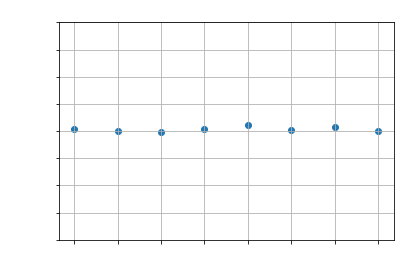

In [ ]:
plt.scatter(xaxis, sentiment[0])
plt.grid()
plt.title(f[0] + ' Sentiment Per Sentence', color='w')
plt.xlabel('Sentence', color='w')
plt.ylabel('Sentiment', color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.ylim(-1,1)

In [ ]:
xaxis = []
for i in range(len(sentiment[2])): # sentiment[0] is the list of sentiments for the first key word
  xaxis.append(i)
print("The xaxis is {}.".format(xaxis))

The xaxis is [0, 1, 2, 3, 4, 5, 6, 7, 8].


(-1.0, 1.0)

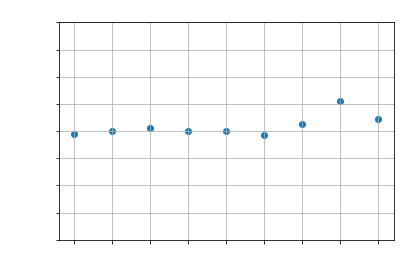

In [ ]:
plt.scatter(xaxis, sentiment[2])
plt.grid()
plt.title(f[2] + ' Sentiment Per Sentence', color='w')
plt.xlabel('Sentence', color='w')
plt.ylabel('Sentiment', color='w')
plt.xticks(color='w')
plt.yticks(color='w')
plt.ylim(-1,1)

## <font color='black'>Step 10. Store All article data in DataFrame </font>  
<font color='grey'>Note: This is not just the filtered data, this contains all information from each web page. While not used in this project, it represents all of the original data used in this run. It can be used for reference.</font> 

In [ ]:
# Put parsed data into Pandas DataFrame
df = pd.DataFrame(out_list)
df

,Text,url
0,Urlaubsgäste aus den Kreisen Gütersloh und War...,https://www.zeit.de/gesellschaft/2020-06/coron...
1,Trotz Kontaktbeschränkungen sind Zehntausende ...,https://www.zeit.de/gesellschaft/2020-06/gross...
2,"Maskenpflicht in Zügen und Flugzeugen, Einbahn...",https://www.zeit.de/gesellschaft/zeitgeschehen...
3,Mehr als ein Dutzend verletzte Polizisten und ...,https://www.zeit.de/gesellschaft/zeitgeschehen...
4,Die Zahl der Sterbefälle in Deutschland im Mai...,https://www.zeit.de/gesellschaft/2020-06/coron...
5,In der Schweiz soll die Ehe für alle zugelasse...,https://www.zeit.de/gesellschaft/familie/2020-...
6,Ein Londoner Gericht hat einen Mann mit IS-Ver...,https://www.zeit.de/gesellschaft/zeitgeschehen...
7,Nach den Ausschreitungen in der Stuttgarter In...,https://www.zeit.de/gesellschaft/zeitgeschehen...
8,Das Ziel des gemeinsamen Lernens von Schülerin...,https://www.zeit.de/gesellschaft/schule/2020-0...
9,In Göttingen haben Bewohner und Bewohnerinnen ...,https://www.zeit.de/gesellschaft/2020-06/goett...


<font color='orange'>Step 8.</font> <font color='skyblue'> Search </font>  All sentences for Key Words and return only those consisting of a key word

